In [1]:
# Install a conda package in the current Jupyter kernel
import sys

import string
import gensim
from gensim import corpora, models
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

import warnings
warnings.filterwarnings('ignore')


# We import sklearn.
import sklearn

import csv
import gc
import pandas as pd
import random
import pickle

csv.field_size_limit(sys.maxsize)

In [2]:
def uniquify(seq, idfun=None): 
   # order preserving
   if idfun is None:
       def idfun(x): return x
   seen = {}
   result = []
   for item in seq:
       marker = idfun(item)
       if marker in seen: continue
       seen[marker] = 1
       result.append(item)
   return result

In [3]:
from datetime import timedelta, date

years = [7,10,11,12,13,14,15,16]


def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)


dates = {}        
for year in years:
    days = []
    year = year + 2000
    start = date(year, 1, 1)
    end = date(year, 12, 31)
    for dt in daterange(start, end):
        days.append(dt.strftime("%m-%d-%Y"))
    dates[year] = days

In [4]:
docs = []
years = [2007,2010,2011,2012,2013,2014,2015,2016]
BGT_jobID_50 = []

a = 0
for year in years:
    for date in dates[year]:
        a += 1
        date_docs = []
        filename = '../../text_data/JobText_US_' + date + '.txt'
        with open(filename) as file:
            i = 0 
            nums = random.sample(range(1, 10000), 50)
            for line in csv.reader(file, dialect="excel-tab"):
                i += 1
                if line[0] != '' and i in nums:
                    BGT_jobID_50.append(line[1])
                    docs.append(line[3])

In [6]:
stop_words = set(stopwords.words('english'))

In [7]:
# stemmer
p_stemmer = PorterStemmer()

In [8]:
documents = []

for i in docs:
    # tokenize text
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = [x.lower() for x in tokenizer.tokenize(i)]

    # remove stop words, numbers, and short words from tokens
    stopped_tokens = [i for i in tokens if not i in stop_words and len(i) > 3 and not i.isdigit()]

    # stem and lemmatize tokens
    stemmed_tokens = [p_stemmer.stem(WordNetLemmatizer().lemmatize(i, pos='v')) for i in stopped_tokens]
    
    # add tokens to list
    documents.append(stemmed_tokens)

In [10]:
print(len(documents))

In [11]:
# pickle documents
docfile = open('documents.pkl', 'wb')
pickle.dump(documents, docfile, pickle.HIGHEST_PROTOCOL)

# pickle BGT ID dictionary
idfile = open('bgt_50.pkl', 'wb')
pickle.dump(BGT_jobID_50, idfile, pickle.HIGHEST_PROTOCOL)

In [12]:
# turn tokenize documents into a id - term dictionary
#documents = []
dictionary = corpora.Dictionary(documents)

len(dictionary)

In [13]:
# filter out words that are too frequent or too infrequent
dictionary.filter_extremes(no_below=0.02, no_above=0.5, keep_n=100000)
dictionary.save('dictionary_50')
len(dictionary)

In [14]:
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(document) for document in documents]
corpora.MmCorpus.serialize('corpus_50.mm', corpus)

In [15]:
# load dictionary, corpus, documents, and IDs
dictionary = dictionary.load('dictionary_50')
corpus = corpora.MmCorpus('corpus_50.mm')

docfile = open('documents.pkl', 'rb')
documents = pickle.load(docfile)

idfile = open('bgt_50.pkl', 'rb')
BGT_jobID_50 = pickle.load(idfile)

In [16]:
# creating object for LDA model
Lda = gensim.models.ldamodel.LdaModel

def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = Lda(corpus, num_topics=num_topics, id2word=dictionary, chunksize=50000, update_every=1, passes=4)        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(num_topics)

    return model_list, coherence_values

In [7]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=documents, start=10, limit=51, step=5)

10
15
20
25
30
35
40
45
50


In [8]:
# Can take a long time to run, second half
model_list_2, coherence_values_2 = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=documents, start=55, limit=76, step=5)

55
60
65
70
75


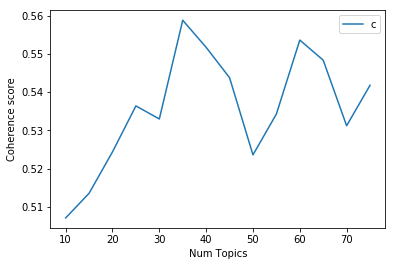

In [9]:
# Show graph
limit=76; start=10; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values + coherence_values_2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [10]:
# Print the coherence scores
for m, cv in zip(x, coherence_values + coherence_values_2):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.5071
Num Topics = 15  has Coherence Value of 0.5135
Num Topics = 20  has Coherence Value of 0.5244
Num Topics = 25  has Coherence Value of 0.5364
Num Topics = 30  has Coherence Value of 0.533
Num Topics = 35  has Coherence Value of 0.5588
Num Topics = 40  has Coherence Value of 0.5517
Num Topics = 45  has Coherence Value of 0.5438
Num Topics = 50  has Coherence Value of 0.5236
Num Topics = 55  has Coherence Value of 0.5343
Num Topics = 60  has Coherence Value of 0.5536
Num Topics = 65  has Coherence Value of 0.5483
Num Topics = 70  has Coherence Value of 0.5312
Num Topics = 75  has Coherence Value of 0.5418


In [7]:
optimal_model = Lda(corpus, num_topics=35, id2word=dictionary, chunksize=50000, update_every=1, passes=4)     
optimal_model.save("lda_model_50")

In [7]:
num_topics = 35
optimal_model = Lda.load("lda_model_50")
dictionary = dictionary.load('dictionary_50')
corpus = corpora.MmCorpus('corpus_50.mm')

In [8]:
# Visualize the topics
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary, mds="tsne")

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
14      36.950199    3.681409       1        1  8.489586
11     -18.148260 -161.925262       2        1  6.914300
18     -75.428009   49.825958       3        1  5.735826
25    -189.128571  107.629433       4        1  4.749551
6       -6.111089   51.054386       5        1  4.475823
15      94.234009  -24.076494       6        1  4.180699
27       5.166480  180.424667       7        1  4.078949
4       24.251749  -64.618790       8        1  3.945702
1      194.882080  -98.536087       9        1  3.749357
20     -25.407570  -16.380907      10        1  3.595314
29     -38.819431  117.495987      11        1  3.481502
16      37.519127 -212.087128      12        1  3.174281
26    -114.204033  113.762772      13        1  3.102614
13     156.972076    8.068001      14        1  2.816104
28     187.135193   71.929626      15        1  2.608397
12     110.084007  -88.885452      16        1  2.482879
0       91.717545   54.293518      17        1  2.448755
17     120.965904 -169.814377      18        1  2.384956
8       49.040939  112.015244      19        1  2.277345
22    -103.422920 -152.098526      20        1  2.242891
24     -43.725704  -87.685982      21        1  2.198198
21     -73.007393  208.655731      22        1  2.059864
34    -121.466545  -88.011772      23        1  1.964197
10    -151.715729   34.737988      24        1  1.922846
23       9.877481  261.890778      25        1  1.785742
5      -92.457947  -21.320711      26        1  1.677090
2     -161.484482  181.930237      27        1  1.614327
30     101.014374  172.258545      28        1  1.581283
19    -277.745758    9.659531      29        1  1.480969
31      50.141636 -126.818665      30        1  1.350137
32    -201.198257 -125.761406      31        1  1.333518
3      -79.842216 -248.409424      32        1  1.201774
7      190.806183  149.456451      33        1  1.141883
33    -193.671356  -32.630970      34        1  0.982424
9      243.369110  -16.627928      35        1  0.770925, topic_info=      Category           Freq         Term          Total  loglift  logprob
term                                                                       
51     Default  139665.000000         sale  139665.000000  30.0000  30.0000
718    Default   68682.000000         nurs   68682.000000  29.0000  29.0000
455    Default  104135.000000         care  104135.000000  28.0000  28.0000
118    Default   73428.000000        engin   73428.000000  27.0000  27.0000
145    Default  100815.000000          job  100815.000000  26.0000  26.0000
13     Default  204034.000000       custom  204034.000000  25.0000  25.0000
38     Default  102596.000000        pleas  102596.000000  24.0000  24.0000
722    Default   65648.000000      patient   65648.000000  23.0000  23.0000
0      Default  109788.000000      account  109788.000000  22.0000  22.0000
99     Default   96737.000000      contact   96737.000000  21.0000  21.0000
1047   Default   51660.000000        store   51660.000000  20.0000  20.0000
957    Default   40063.000000       driver   40063.000000  19.0000  19.0000
177    Default   95564.000000      project   95564.000000  18.0000  18.0000
176    Default  139707.000000      product  139707.000000  17.0000  17.0000
285    Default   77089.000000       health   77089.000000  16.0000  16.0000
337    Default  168042.000000      develop  168042.000000  15.0000  15.0000
39     Default  118453.000000         post  118453.000000  14.0000  14.0000
108    Default   71079.000000       design   71079.000000  13.0000  13.0000
1619   Default   29784.000000  careerbuild   29784.000000  12.0000  12.0000
181    Default   50605.000000      recruit   50605.000000  11.0000  11.0000
1014   Default   85473.000000        email   85473.000000  10.0000  10.0000
416    Default  111020.000000       system  111020.000000   9.0000   9.0000
623    Default   66725.0

In [9]:
optimal_model.show_topics(num_topics=35)

[(0,
  '0.057*"engin" + 0.029*"design" + 0.028*"project" + 0.015*"develop" + 0.012*"construct" + 0.009*"employ" + 0.008*"system" + 0.008*"technic" + 0.007*"opportun" + 0.006*"softwar"'),
 (1,
  '0.029*"email" + 0.025*"careerbuild" + 0.025*"appli" + 0.015*"save" + 0.014*"websit" + 0.014*"account" + 0.014*"agre" + 0.013*"compli" + 0.012*"inform" + 0.012*"specifi"'),
 (2,
  '0.032*"guest" + 0.026*"food" + 0.025*"restaur" + 0.014*"acirc" + 0.012*"team" + 0.012*"member" + 0.006*"oper" + 0.006*"benefit" + 0.006*"beverag" + 0.006*"ensur"'),
 (3,
  '0.024*"bank" + 0.016*"custom" + 0.015*"unit" + 0.015*"branch" + 0.013*"state" + 0.012*"teller" + 0.010*"island" + 0.008*"financi" + 0.007*"banker" + 0.006*"republ"'),
 (4,
  '0.032*"applic" + 0.015*"must" + 0.012*"inform" + 0.012*"document" + 0.009*"appli" + 0.009*"complet" + 0.008*"educ" + 0.008*"submit" + 0.008*"veteran" + 0.008*"elig"'),
 (5,
  '0.030*"recruit" + 0.021*"resourc" + 0.018*"employ" + 0.016*"human" + 0.014*"job" + 0.012*"candid" + 0

In [ ]:
topics = {}
vectors = []
for i,idx in enumerate(documents):
        # get the topic percentages for each document
        bow = dictionary.doc2bow(idx)
        v = optimal_model.get_document_topics(bow)
        
        # key => value, document number => topic vector
        topics[i] = v
        
        # iterate through the topic vector
        dict = {}
        for j,jdx in enumerate(v):
            # key => value, topic number => percentage of document
            dict[jdx[0]] = jdx[1]

        # give the dictionary the same number of keys as topics, one for each topic
        vector = []
        for k in range(num_topics):
            # if the topic was in the original vector, use the given percentage
            if k in dict.keys():
                vector.append(dict[k])
            # else give the topic the percentage zero
            else:
                vector.append(0)
        # add the vector to the set of document vectors
        vectors.append(np.asarray([vector]))

In [ ]:
# pickle vectors
vecfile = open('vectors_50.pkl', 'wb')
pickle.dump(vectors, vecfile, pickle.HIGHEST_PROTOCOL)

In [20]:
vecfile = open('vectors_50.pkl', 'rb')
vectors = pickle.load(vecfile)

In [29]:
years = ['07','11','12','13','14','15','16']
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
titles = {}

"""Main"""
for year in years:
    for month in months:
        filename = '../Main Text Files/Main 20' + year +'/Main 20' + year + '-'+ month +'.txt'
        with open(filename, encoding='latin-1') as file:
            for line in csv.reader(file, dialect="excel-tab"):
                if line[0] in BGT_jobID_50:
                    titles[line[0]] = line[3]

In [9]:
# pickle titles
docfile = open('titles_50.pkl', 'wb')
pickle.dump(titles, docfile, pickle.HIGHEST_PROTOCOL)

In [25]:
titlefile = open('titles_50.pkl', 'rb')
titles = pickle.load(titlefile)

In [27]:
def top_5_similar(vectors):
    # choose five random job postings
    for j in range(5):
        index = np.random.randint(0,len(titles) - 1)
        
        # find cosine similarity and euclidean distance from the given vector for every other job posting
        cosines = {}
        euclideans = {}
        for i,ind in enumerate(vectors):
            if i != index:
                cosines[sklearn.metrics.pairwise.cosine_similarity(vectors[index],vectors[i])[0][0]] = i
                euclideans[sklearn.metrics.pairwise.euclidean_distances(vectors[index],vectors[i])[0][0]] = i

        # find the 5 highest cosine similarity and 5 shortest euclidean distance
        top_5_cosine = sorted(cosines.keys(), reverse=True)[:6]
        top_5_euclidean = sorted(euclideans.keys())[:6]
        
        # print out the cosine similarities
        print("\nTop 5 cosine similarity to:", titles[BGT_jobID_50[index]])
        for i,indx in enumerate(top_5_cosine):
            print("  ", round(top_5_cosine[i], 3), titles[BGT_jobID_50[cosines[top_5_cosine[i]]]])
            
        # print out the euclidean distances
        print("Lowest 5 euclidean distance from:", titles[BGT_jobID_50[index]])
        for k,inx in enumerate(top_5_euclidean):
            print("  ", round(top_5_euclidean[k], 3), titles[BGT_jobID_50[euclideans[top_5_euclidean[k]]]])

In [28]:
top_5_similar(vectors)


Top 5 cosine similarity to: Process Improve Consultant I
   0.999 Contract Analyst/Vendor Management
   0.999 Director Level Business Project Manager
   0.998 Project Manager
   0.998 Fso - Advisory Services Manager - Strategic Technology Advisory Services
   0.998 Business Operation Analyst
   0.998 Senior Business It Risk Manager - Operational Risk/Mortgage Banking - , , Tam
Lowest 5 euclidean distance from: Process Improve Consultant I
   0.04 Contract Analyst/Vendor Management
   0.047 Director Level Business Project Manager
   0.055 Project Manager
   0.063 Communications Lead
   0.068 Ib Operations - Global Cash - Program/Project Manager - Vice President
   0.069 Transaction Advisory Services Senior consultant - M&A Operational Transaction Services

Top 5 cosine similarity to: Management Trainee
   0.986 110547884
   0.955 Sales Management Trainee
   0.954 Management Trainee
   0.952 Management Trainee
   0.941 Management Trainee
   0.939 Management Trainee
Lowest 5 euclidean di

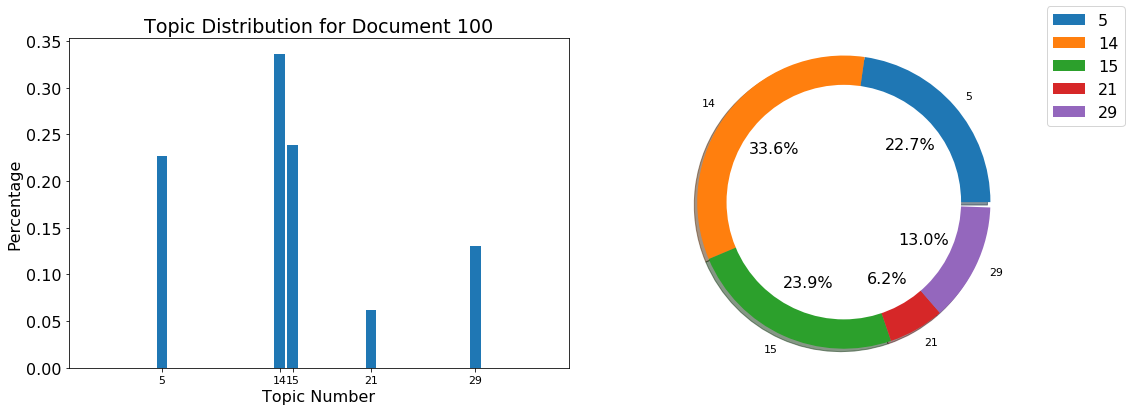

In [32]:
# import matplotlib
import matplotlib.pyplot as plt

doc_num = 100
labels = np.where(vectors[doc_num][0] != 0)[0]
plt.rcParams['figure.figsize'] = (16,6)
plt.rcParams.update({'font.size': 16})
plt.rc('xtick', labelsize=11)    

topics = np.arange(35)

f, (ax1, ax2) = plt.subplots(1, 2)

ax1.bar(range(num_topics), vectors[doc_num][0], align='center')
ax1.set_xticks(labels)
ax1.set_ylabel('Percentage')
ax1.set_xlabel('Topic Number')
ax1.set_title('Topic Distribution for Document ' + str(doc_num))

ax2.pie(vectors[doc_num][0][labels], autopct='%1.1f%%', labels=labels, shadow=True)
plt.legend([topics[i] for i in labels], loc=1, borderaxespad=-2)

#draw circle
centre_circle = plt.Circle((0,0),0.80,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
def top_1000_similar(vectors):
        indices = []
        index = 32535
        cosines = {}
        for i,ind in enumerate(vectors):
            if i != index:
                cosines[sklearn.metrics.pairwise.cosine_similarity(vectors[index],vectors[i])[0][0]] = i

        top_1000_cosine = sorted(cosines.keys(), reverse=True)[:1001]
        print("\nTop 1000 cosine similarity to:", titles[index])
        for i,ind in enumerate(top_1000_cosine):
            print("  ", round(ind, 3), titles[cosines[ind]])
            indices.append(cosines[ind])
            
        return indices

indices = top_1000_similar(vectors)